# Debt Portfolio Analysis - Case Study

## Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing

In [10]:
df = pd.read_csv(r"C:\Users\idosh\Downloads\book_data.csv")
df.head()

,Portfolio #,ID,Gender,Date_of_birth,city,county,postcode,original_sum,duedate,current balance,principal,interest,fee 1,fee 2,fee 3,fee 4,apr,interest_per_day,total_paid
0,1,1,Male,20/08/1973,Montcada,Valencia,46113,1000,23/12/2023,2169.89,1000.0,250.00,243.0,0.0,830.0,89.89,300.00%,0.82%,185.11
1,1,2,Male,06/06/1992,Picassent,Valencia,46220,100,01/01/2024,221.67,100.0,4.67,24.3,0.0,100.0,17.00,240.17%,0.66%,0.00
2,1,3,Female,11/10/1960,Coslada,Madrid,28822,300,31/12/2023,693.30,300.0,51.00,72.9,0.0,282.3,60.00,204.00%,0.56%,0.00
3,1,4,Female,10/11/1976,Alicante,Alicante,3003,1000,31/12/2023,2171.00,1000.0,126.00,243.0,74.0,801.0,170.00,240.00%,0.66%,0.00
4,1,5,Female,13/07/1993,Santa margarita de montbui,Barcelona,8710,100,13/01/2024,237.00,100.0,17.00,24.3,0.0,100.0,20.00,204.00%,0.56%,0.00


In [11]:
#changing dates columns from string type to date type
#uniting all fees columns to one fee column
#adding customer_age column
df['Date_of_birth'] = pd.to_datetime(df['Date_of_birth'], dayfirst=True, errors='coerce')
df['duedate'] = pd.to_datetime(df['duedate'], dayfirst=True, errors='coerce')
fee_cols = ['fee 1', 'fee 2', 'fee 3', 'fee 4']
df['total_fees'] = df[fee_cols].sum(axis=1) # in the columns directory, there wasn't any mention of differences between the 4 fees, so I'm assuming there isn't any
today = pd.Timestamp.today()
df['Customer_age'] = (today - df['Date_of_birth']).dt.days // 365

df.head()

,Portfolio #,ID,Gender,Date_of_birth,city,county,postcode,original_sum,duedate,current balance,...,interest,fee 1,fee 2,fee 3,fee 4,apr,interest_per_day,total_paid,total_fees,Customer_age
0,1,1,Male,1973-08-20,Montcada,Valencia,46113,1000,2023-12-23,2169.89,...,250.00,243.0,0.0,830.0,89.89,300.00%,0.82%,185.11,1162.89,52.0
1,1,2,Male,1992-06-06,Picassent,Valencia,46220,100,2024-01-01,221.67,...,4.67,24.3,0.0,100.0,17.00,240.17%,0.66%,0.00,141.30,33.0
2,1,3,Female,1960-10-11,Coslada,Madrid,28822,300,2023-12-31,693.30,...,51.00,72.9,0.0,282.3,60.00,204.00%,0.56%,0.00,415.20,65.0
3,1,4,Female,1976-11-10,Alicante,Alicante,3003,1000,2023-12-31,2171.00,...,126.00,243.0,74.0,801.0,170.00,240.00%,0.66%,0.00,1288.00,49.0
4,1,5,Female,1993-07-13,Santa margarita de montbui,Barcelona,8710,100,2024-01-13,237.00,...,17.00,24.3,0.0,100.0,20.00,204.00%,0.56%,0.00,144.30,32.0


## Demographics EDA

To determine if there are differences in demographic characteristics that can indicate borrower reliability, we examined:
1. Age - older borrowers tend to have lower default risk.
2. Top cities/counties - if one portfolio is concentrated in a single city/county, it’s riskier during local economic shocks.
3. Gender - it could help us in later stages to understand gaps in case there will be differnces between the portfolios.

In [12]:
profile_stats = df.groupby('Portfolio #').agg(
    Mean_Age=('Customer_age', 'mean'),
    Median_Age=('Customer_age', 'median'),
    Male_Ratio=('Gender', lambda x: (x=='Male').mean()*100)
).round(2)
profile_stats

,Mean_Age,Median_Age,Male_Ratio
Portfolio #,,,
1,41.99,41.5,52.00
2,40.73,40.0,54.33


It appears to be non-significant differences in age or gender.

In [13]:
# top 5 cities and counties per portfolio

top_cities = (
    df.groupby(['Portfolio #', 'city'])
      .size()
      .reset_index(name='Count')
      .sort_values(['Portfolio #', 'Count'], ascending=[True, False])
)

top_cities['Percent_in_Portfolio'] = (
    top_cities['Count'] / top_cities.groupby('Portfolio #')['Count'].transform('sum') * 100
).round(2)

top_counties = (
    df.groupby(['Portfolio #', 'county'])
      .size()
      .reset_index(name='Count')
      .sort_values(['Portfolio #', 'Count'], ascending=[True, False])
)

top_counties['Percent_in_Portfolio'] = (
    top_counties['Count'] / top_counties.groupby('Portfolio #')['Count'].transform('sum') * 100
).round(2)

# show top 5 cities
top_cities.groupby('Portfolio #').head(5)

,Portfolio #,city,Count,Percent_in_Portfolio
91,1,Madrid,19,7.60
25,1,Barcelona,11,4.40
174,1,Álava,9,3.60
81,1,Las palmas de gran canaria,4,1.60
105,1,Murcia,4,1.60
278,2,Madrid,37,12.33
206,2,Barcelona,24,8.00
357,2,Zaragoza,14,4.67
339,2,Valencia,11,3.67
274,2,Lleida,4,1.33


In [14]:
top_counties.groupby('Portfolio #').head(5)

,Portfolio #,county,Count,Percent_in_Portfolio
25,1,Madrid,47,18.80
4,1,Barcelona,31,12.40
21,1,Las Palmas,14,5.60
37,1,Valencia,14,5.60
18,1,Islas Baleares,12,4.80
72,2,Madrid,59,19.67
49,2,Barcelona,53,17.67
85,2,Valencia,20,6.67
45,2,Alicante,16,5.33
87,2,Zaragoza,16,5.33


It appears to be a slight more customers around the cities of Madrid and Barcelona in Portfolio 2 then in Portfolio 1, but not a substantial amount.

## Debts Structure Analysis

The Default date trend can help us understand how defaults behave over time. If a portfolio has a decreasing amount of defaults over time, then the portfolio might be stabilizing or collection efforts have improved.


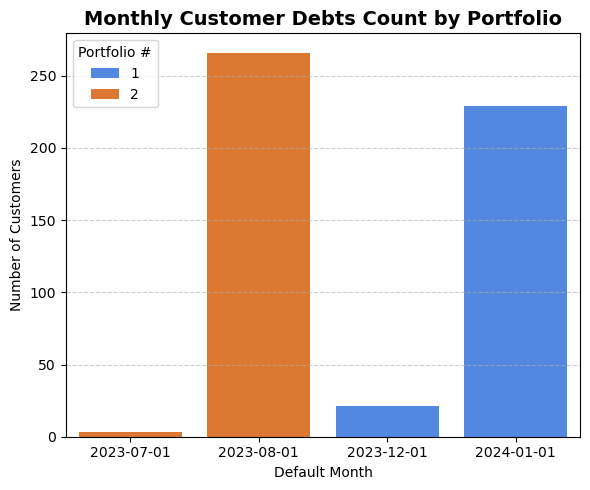

In [15]:
default_trend = (
    df
    .groupby([pd.Grouper(key='duedate', freq='MS'), 'Portfolio #'])['ID']
    .nunique()
    .reset_index(name='count')
)

# count of defaults per month and portfolio
plt.figure(figsize=(6,5))
sns.barplot(
    data=default_trend,
    x='duedate',
    y='count',
    hue='Portfolio #',
    palette=['#3B82F6', '#F97316']
)

plt.title('Monthly Customer Debts Count by Portfolio', fontsize=14, fontweight='bold')
plt.xlabel('Default Month')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



The debts of Portfolio 1 mostly occurred during January 24', and the debts of Portfolio 2 mostly occured during August 23'. This fact prevents us from analyzing the debts activity over time, because there isn't practically more than one month for each portfolio activity.

Nevertheless, debts could be more easily to be collected in the first months after the debt has been made, so this gives a slight advantage to Portfolio 1, as a higher collection potential (it was a larger advantage if today's date was February 24). 

We want to compare three main debt structure columns: Original sum, Principal, and Interest. Compering them can shows how much capital is at stake and what are the expected returns. Portfolios with similar principal but higher interest could have more profitable potential.

We will compare them by computing the means and medians for each one, and then examine each distribution using a boxplot.

In [16]:
# mean stats
mean_stats = (
    df.groupby('Portfolio #')[['original_sum', 'principal', 'interest']]
      .mean()
      .round(2)
)
mean_stats.columns = ['Average_Sum_Borrowed', 'Average_Principal', 'Average_Interest']

# median stats
median_stats = (
    df.groupby('Portfolio #')[['original_sum','principal', 'interest']]
      .median()
      .round(2)
)
median_stats.columns = ['Median_Sum_Borrowed','Median_Principal', 'Median_Interest']

# combine mean and median stats
combined_stats = pd.concat([mean_stats, median_stats], axis=1)

# calculate difference row
diff_percent = ((combined_stats / combined_stats.iloc[0]) - 1) * 100
diff_percent = diff_percent.round(2).astype(str) + '%'

# add difference row
combined_stats.loc['% Difference (vs 1st)'] = diff_percent.iloc[-1]

combined_stats

,Average_Sum_Borrowed,Average_Principal,Average_Interest,Median_Sum_Borrowed,Median_Principal,Median_Interest
Portfolio #,,,,,,
1,425.32,416.54,69.82,300.0,300.0,54.12
2,352.13,344.25,62.2,300.0,300.0,66.0
% Difference (vs 1st),-17.21%,-17.35%,-10.91%,0.0%,0.0%,21.95%


We can clearly see that all of the means in Portfolio 1 are substantially higher than the same means in Portfolio 2. Most of the medians are equivalent, and only the median of interest is surprisingly in favor of Portfolio 2.

Based on these metrics alone, Portfolio 1 appears to be more beneficial: Portfolio 1’s borrowers took larger loans on average, meaning higher nominal exposure and greater potential recovery amounts.


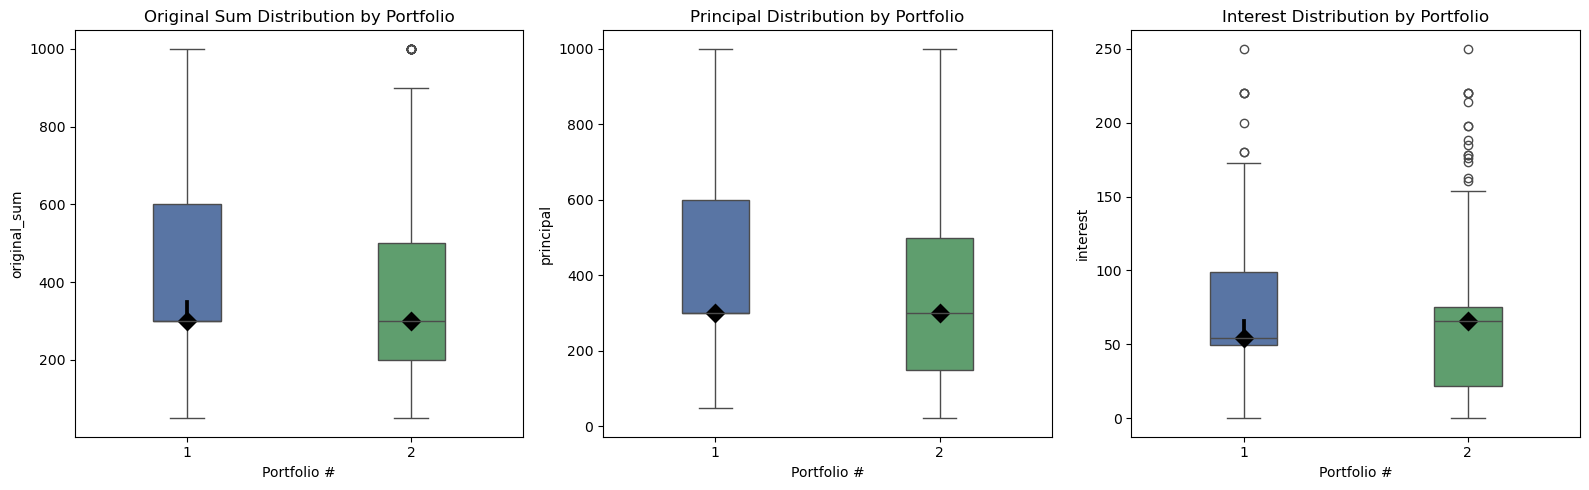

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
palette = ['#4C72B0', '#55A868']

# principal distribution
sns.boxplot(
    data=df, x='Portfolio #', y='principal',
    hue='Portfolio #', palette=palette,
    width=0.3, legend=False, ax=axes[1]
)
sns.pointplot(
    data=df, x='Portfolio #', y='principal',
    estimator='median', linestyle='none', color='black',
    markers='D', markersize=8, ax=axes[1]
)
axes[1].set_title("Principal Distribution by Portfolio")

# interest distribution 
sns.boxplot(
    data=df, x='Portfolio #', y='interest',
    hue='Portfolio #', palette=palette,
    width=0.3, legend=False, ax=axes[2]
)
sns.pointplot(
    data=df, x='Portfolio #', y='interest',
    estimator='median', linestyle='none', color='black',
    markers='D', markersize=8, ax=axes[2]
)
axes[2].set_title("Interest Distribution by Portfolio")

# original sum distribution
sns.boxplot(
    data=df, x='Portfolio #', y='original_sum',
    hue='Portfolio #', palette=palette,
    width=0.3, legend=False, ax=axes[0]
)
sns.pointplot(
    data=df, x='Portfolio #', y='original_sum',
    estimator='median', linestyle='none', color='black',
    markers='D', markersize=8, ax=axes[0]
)
axes[0].set_title("Original Sum Distribution by Portfolio")

plt.tight_layout()
plt.show()

These distributions align with the statistics calculated before.

Portfolio 1 has higher IQR values on all of the three metrics (and more extreme values), meaning it includes larger and more varied loans.

Now, let's examine the current balances and total paid status, so we could understand for each portfolio how much debt remains unpaid and how much has been repaid:

In [18]:
debt_stats = df.groupby('Portfolio #')[['current balance','total_paid']].agg(['mean','median']).round(2)
# computing differences
diff_percent = ((debt_stats.loc[1] - debt_stats.loc[2]) / debt_stats.loc[2] * 100).round(2)
#replacing 'N/A' for non-division calculations
diff_percent = diff_percent.replace([np.inf, -np.inf, np.nan], 'N/A') 
#adding % only to numeric values
diff_percent = diff_percent.apply(
    lambda x: [f"{v}%" if isinstance(v, (int, float, np.integer, np.floating)) else v for v in x]
    if isinstance(x, (pd.Series, list)) else
    (f"{x}%" if isinstance(x, (int, float, np.integer, np.floating)) else x)
)
debt_stats.loc['% Difference (vs 2nd)'] = diff_percent

debt_stats

current balance        total_paid       
                                 mean median       mean median
Portfolio #                                                   
1                             5969.85  693.3     107.67   7.64
2                              750.14  693.3      98.99    0.0
% Difference (vs 2nd)         695.83%   0.0%      8.77%    N/A

The average current balance in Portfolio 1 is almost 7 times higher, which indicates structural differences between the portfolios (will be discussed later on).

The gap between mean and median in Portfolio 1 in current balance reveals heavy right-skewness, meaning only a handful of debtors owe huge balances that inflate the average. This righ-skewness of Portfolio 1 appears also in the total paid, meaning a few borrowers pay significantly more, while most pay little.

The typical borrower (median) owes roughly the same amount in both portfolios. 

Average repayments are slightly higher in Portfolio 1, but the gap is small relative to the imbalance in balances.

In contrast to the first portfolio, the current balance of Portfolio 2 looks homogeneous and stable (similar mean and median), indicating fewer extreme outliers and a healthier distribution of balances. But, the total paid of Portfolio 2 tells us another thing: half of Portfolio 2’s debtors never made a payment, while Portfolio 1 shows at least some partial repayment activity across most customers.

An explanation for the initial gap between the portfolios' means potentially be that the fees are, for some reason, so drastically different that they are the ones that create this gap. Even though it is unlikely, we need to make sure that this is not the case:

In [19]:
fees_stats = (
    df.groupby('Portfolio #')[['total_fees']]
      .agg(['mean', 'median'])
      .round(2)
)

# Compute % difference of portfolio 1 vs 2
diff_percent = ((fees_stats.loc[1] - fees_stats.loc[2]) / fees_stats.loc[2] * 100).round(2)
diff_percent = diff_percent.astype(str) + '%'
fees_stats.loc['% Difference (vs 2nd)'] = diff_percent
fees_stats

total_fees       
                            mean median
Portfolio #                            
1                          524.3  415.2
2                         427.34  400.2
% Difference (vs 2nd)     22.69%  3.75%

Indeed, we can exclude the differences in the fees as the reason behind the current balance gaps, as well as differences in the principles and interests (we have already seen they are much modest). 

## Financial KPIs Analysis

There are main financial KPI's that could help us judging each portfolio:

1. Recovery Rate: measures how much of the original loan value has been recovered so far. High values indicate stronger repayment relative to the total debt issued.
   
2. Collection Efficiency Ratio (CER): shows the efficiency of converting total collectible value (paid + owed) into cash. Higher CER means more of the collectible balance has already been recovered.

3. Debt-to-Original Ratio (DOR): indicates how much the remaining balance has inflated compared to the original loan value. Higher DOR implies heavier delinquency or accumulated interest and penalties.

4. Average Payment per Debtor: shows the average amount recovered from each borrower. Higher values mean deeper or more concentrated repayment among debtors.


In [20]:
# aggregate required columns
agg = df.groupby('Portfolio #').agg({
    'original_sum': 'sum',
    'total_paid': 'sum',
    'current balance': 'sum',
    'ID': 'nunique'  # count unique debtors to use later
}).reset_index()

# rename columns
agg.columns = ['Portfolio #', 'Original Sum', 'Total Paid', 'Current Balance', 'Unique Debtors']

# calculate KPIs
agg['Recovery Rate (%)'] = (agg['Total Paid'] / agg['Original Sum']) * 100
agg['CER (%)'] = (agg['Total Paid'] / (agg['Total Paid'] + agg['Current Balance'])) * 100
agg['DOR (%)'] = (agg['Current Balance'] / agg['Original Sum']) * 100
agg['Avg Payment per Debtor'] = agg['Total Paid'] / agg['Unique Debtors']


kpi = agg[['Portfolio #', 'Recovery Rate (%)', 'CER (%)', 'DOR (%)', 'Avg Payment per Debtor']].round(2)

kpi

,Portfolio #,Recovery Rate (%),CER (%),DOR (%),Avg Payment per Debtor
0,1,25.32,1.77,1403.61,107.67
1,2,28.11,11.66,213.03,98.99


The Recovery Rate shows that Portfolio 2 has a slightly stronger repayment base, meaning a bit more of the original debt has already been collected. The CER tells us that Portfolio 2 is much more efficient at converting collectible debt into cash, Portfolio 1’s collections are almost stagnant relative to its inflated balances. The DOR tells us that Portfolio 1’s debts have grown 14 times larger (!) than the original loans, showing that most borrowers haven’t paid for a long time and balances have piled up. Portfolio 2’s debts roughly doubled, which is far healthier. The Avg Payment per Debtor tells us that on average, debtors in Portfolio 1 have paid a bit more, but the difference is small and doesn’t compensate for its much weaker recovery performance overall.

**According to this analysis, Portfolio 2 is clearly superior: while both have similar recovery depth per debtor, Portfolio 2 collects more efficiently and has much lower inflation risk. The larger loan sizes and higher interest rates in Portfolio 1 that we detected at early stages of the analysis would translate into higher profits only if the portfolios were with the same efficiency and risk level, which is not the case.
The large difference in the mean current balance between the portfolios that we detected at early stages indicates that Portfolio 1 carries far heavier outstanding debts per borrower. This gap aligns with the KPI results showing Portfolio 1’s very high DOR and low CER, since such large unpaid balances inflate total exposure but are much harder to collect.**